In [ ]:
########################################
# TP558 - Classificação de Sons Urbanos
# CNN + Log-Mel Spectrogram (UrbanSound8K)
########################################

# Esta célula é para COLAB. Se estiver em Jupyter local,
# comente a linha de instalação de pacotes se já tiver tudo instalado.
'''
!pip install librosa soundfile tensorflow==2.15.0 --quiet
%pip install pandas matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# --- CONFIGURAÇÕES DE CAMINHO ---
# Ajuste apenas esta variável base
BASE_DIR = r"C:\Users\Tulio Volpato\Desktop\Projeto Final TP558\Dataset"
METADATA_PATH = os.path.join(BASE_DIR, "UrbanSound8K.csv")
AUDIO_PATH = BASE_DIR

# --- PARÂMETROS DE ÁUDIO ---
SR = 22050
DURATION = 4.0
SAMPLES = int(SR * DURATION) # ~88200 amostras
N_MELS = 64
N_FFT = 1024
HOP_LENGTH = 256

# --- SELEÇÃO DE FOLDS ---
# Padrão UrbanSound8K: Treinar em 9 folds, testar em 1 (Fold 10)
TRAIN_FOLDS = [1, 2, 3, 4, 5, 6, 7, 8, 9]
TEST_FOLDS = [10]

# Carregamento do Metadata (apenas uma vez)
if os.path.exists(METADATA_PATH):
    metadata = pd.read_csv(METADATA_PATH)
    print("Metadata carregado. Total de arquivos:", len(metadata))
else:
    raise FileNotFoundError(f"Arquivo não encontrado: {METADATA_PATH}")


Metadata carregado. Total de arquivos: 8732


In [2]:
def augment_audio(y, noise_factor=0.005, gain_range=(0.8, 1.2)):
    """Aplica Ganho e Ruído Branco para aumentar a variabilidade do treino."""
    # Ganho aleatório
    gain = np.random.uniform(gain_range[0], gain_range[1])
    y = y * gain

    # Ruído
    noise = np.random.randn(len(y)) * noise_factor
    y = y + noise

    # Normalização
    max_val = np.max(np.abs(y)) + 1e-8
    y = y / max_val
    return y

def load_audio_logmel(file_path, sr=SR, samples=SAMPLES, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH, augment=False):
    try:
        y, _ = librosa.load(file_path, sr=sr, mono=True)
    except Exception as e:
        print(f"Erro ao ler {file_path}: {e}")
        return None

    # Pad ou Trim para garantir tamanho fixo
    if len(y) < samples:
        pad_width = samples - len(y)
        y = np.pad(y, (0, pad_width), mode='constant')
    else:
        y = y[:samples]

    # Aplica Augmentation somente se solicitado (Treino)
    if augment:
        y = augment_audio(y)

    # Extração de Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # Normalização Min-Max [0, 1]
    min_val = log_mel_spec.min()
    max_val = log_mel_spec.max()
    log_mel_norm = (log_mel_spec - min_val) / (max_val - min_val + 1e-8)

    return log_mel_norm.astype(np.float32)

In [3]:
def build_dataset_from_folds(folds, augment=False):
    X = []
    y = []
    
    # Filtra o metadata apenas para os folds solicitados
    df_filtered = metadata[metadata['fold'].isin(folds)]
    
    print(f"Processando Folds {folds} | Total: {len(df_filtered)} arquivos...")

    for _, row in df_filtered.iterrows():
        file_name = row["slice_file_name"]
        fold = row["fold"]
        class_id = row["classID"]
        
        # Caminho: Dataset/foldX/filename.wav
        file_path = os.path.join(AUDIO_PATH, f"fold{fold}", file_name)

        if not os.path.exists(file_path):
            continue

        log_mel = load_audio_logmel(file_path, augment=augment)
        
        if log_mel is not None:
            # Adiciona dimensão de canal (Height, Width, 1) para CNN
            log_mel = np.expand_dims(log_mel, axis=-1)
            X.append(log_mel)
            y.append(class_id)

    return np.array(X), np.array(y)

# --- EXECUÇÃO DO CARREGAMENTO ---
print("--- Carregando Treino (Com Augmentation) ---")
X_trainval, y_trainval = build_dataset_from_folds(TRAIN_FOLDS, augment=True)

print("\n--- Carregando Teste (Sem Augmentation) ---")
X_test, y_test = build_dataset_from_folds(TEST_FOLDS, augment=False)

# Divisão Treino / Validação (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval
)

print(f"\nShapes Finais:\nTreino: {X_train.shape}\nValidação: {X_val.shape}\nTeste: {X_test.shape}")

--- Carregando Treino (Com Augmentation) ---
Processando Folds [1, 2, 3, 4, 5, 6, 7, 8, 9] | Total: 7895 arquivos...

--- Carregando Teste (Sem Augmentation) ---
Processando Folds [10] | Total: 837 arquivos...

Shapes Finais:
Treino: (6316, 64, 345, 1)
Validação: (1579, 64, 345, 1)
Teste: (837, 64, 345, 1)


In [4]:
# Calcular pesos de classe (Dataset desbalanceado)
classes_unicas = np.unique(y_train)
class_weights_array = compute_class_weight(class_weight="balanced", classes=classes_unicas, y=y_train)
class_weights = {int(c): float(w) for c, w in zip(classes_unicas, class_weights_array)}

def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        # Bloco 1
        layers.Conv2D(32, (3, 3), padding="same", kernel_regularizer=regularizers.l2(1e-4), input_shape=input_shape),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((2, 2)),
        
        # Bloco 2
        layers.Conv2D(64, (3, 3), padding="same", kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((2, 2)),
        
        # Bloco 3
        layers.Conv2D(128, (3, 3), padding="same", kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((2, 2)),
        
        # Camadas Densas
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5), # Dropout ajuda a reduzir o overfitting
        layers.Dense(num_classes, activation="softmax")
    ])
    return model

model = create_cnn_model(X_train.shape[1:], len(classes_unicas))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks - Atualizado para salvar em .keras
my_callbacks = [
    callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, verbose=1),
    callbacks.ModelCheckpoint(filepath="best_model.keras", monitor="val_loss", save_best_only=True)
]

print("Iniciando treinamento...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60, 
    batch_size=32,
    callbacks=my_callbacks,
    class_weight=class_weights
)



Iniciando treinamento...
Epoch 1/60


198/198 [==============================] - 86s 422ms/step - loss: 1.7582 - accuracy: 0.3490 - val_loss: 3.8447 - val_accuracy: 0.0431 - lr: 0.0010
Epoch 2/60
198/198 [==============================] - 83s 421ms/step - loss: 1.3988 - accuracy: 0.4886 - val_loss: 3.7962 - val_accuracy: 0.1096 - lr: 0.0010
Epoch 3/60
198/198 [==============================] - 83s 417ms/step - loss: 1.2180 - accuracy: 0.5686 - val_loss: 2.0607 - val_accuracy: 0.2698 - lr: 0.0010
Epoch 4/60
198/198 [==============================] - 83s 418ms/step - loss: 1.0855 - accuracy: 0.6252 - val_loss: 1.5163 - val_accuracy: 0.4661 - lr: 0.0010
Epoch 5/60
198/198 [==============================] - 83s 418ms/step - loss: 1.0104 - accuracy: 0.6491 - val_loss: 5.0769 - val_accuracy: 0.1590 - lr: 0.0010
Epoch 6/60
198/198 [==============================] - 83s 418ms/step - loss: 0.9497 - accuracy: 0.6719 - val_loss: 4.3992 - val_accuracy: 0.2812 - lr: 0.0010
Epoch 7/60
198/198 [===

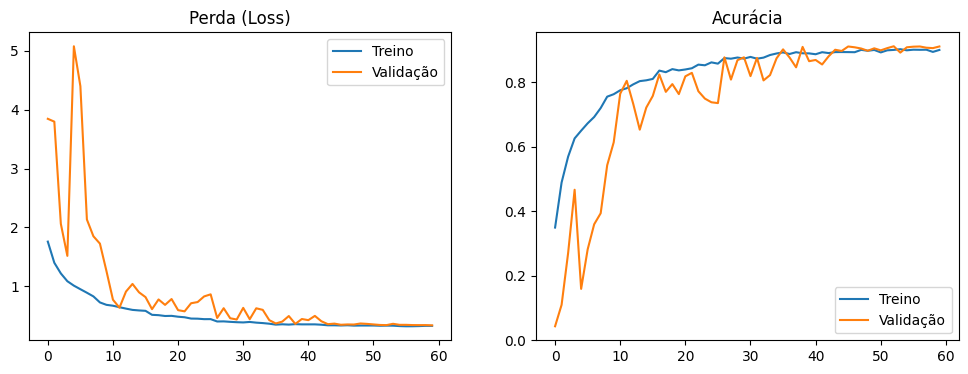


--- AVALIAÇÃO FINAL (FOLD 10) ---
Acurácia no Teste: 0.6308
27/27 [==============================] - 3s 98ms/step

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.62      0.56      0.59       100
           1       0.56      0.55      0.55        33
           2       0.69      0.43      0.53       100
           3       0.60      0.71      0.65       100
           4       0.52      0.69      0.59       100
           5       0.73      0.49      0.59        93
           6       0.61      0.94      0.74        32
           7       0.64      0.82      0.72        96
           8       0.80      0.71      0.75        83
           9       0.63      0.57      0.60       100

    accuracy                           0.63       837
   macro avg       0.64      0.65      0.63       837
weighted avg       0.64      0.63      0.63       837


Matriz de Confusão:
[[56  0  2  0 13  7  1 16  5  0]
 [ 0 18  0 13  0  0  0  0  0  2]
 [ 2  0 43

In [5]:
# Gráficos de Evolução
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Treino")
plt.plot(history.history["val_loss"], label="Validação")
plt.title("Perda (Loss)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Treino")
plt.plot(history.history["val_accuracy"], label="Validação")
plt.title("Acurácia")
plt.legend()
plt.show()

# Avaliação Final no Fold 10 (Teste Real)
print("\n--- AVALIAÇÃO FINAL (FOLD 10) ---")
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Acurácia no Teste: {test_acc:.4f}")

# Relatório Detalhado
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred))